## Mesyella-2201793281

# Digit Recognizer using Self Organizing Map

## Architecture

Self organizing map have 2 layers, input vector and output lattice. In the output lattice there are somen neurons, which one of them will be the best matching unit.

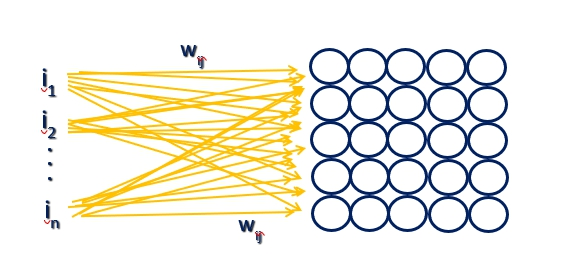

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random as ran
import tensorflow as tf

d:\python 3.6.8\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\python 3.6.8\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\python 3.6.8\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\python 3.6.8\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym

## Input Data

I use MNIST handwritten digit dataset. The dataset normalized to fit into 28x28 pixels. I only use 100 data for training and 15 data to test it.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

x_train = mnist.train.images[:100,:]
y_train = mnist.train.labels[:100,:]
x_test = mnist.train.images[:115,:]
y_test = mnist.train.labels[:115,:]
x_test = x_test[100:115,:]; y_test = y_test[100:115,:]

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [9]:
x_test[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

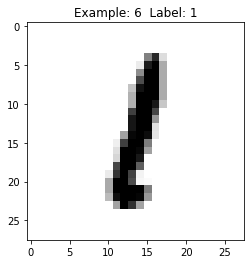

In [3]:
def display_digit(num):
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

display_digit(ran.randint(0, x_train.shape[0]))


## SOM Algorithm

1. Once each neuron’s weights are initialized, every neuron is examined to calculate the distance to inputs by using euclidean.

2. A neuron that has the smallest distance will be chosen as Best Matching Unit(BMU).

3. The radius of a neighborhood of the BMU starts from the specified value and shrinks as the iteration increases. Found Nodes inside of the neighborhood are getting similar by changing their weights

In [4]:
class SOM(object):
    trained = False

    def __init__(self, height, width, dim, iterations=100):
        self.height = height
        self.width = width
        alpha = 0.2
        sigma = max(height, width) / 2
        self.iterations = abs(int(iterations))
        self.graph = tf.Graph()

        with self.graph.as_default():
            
            self.weight = tf.Variable(tf.random_normal([height * width, dim]))
            self.location = tf.constant(np.array(list(self.neuron_locations(height, width))))

            self.input = tf.placeholder("float", [dim])
            self.iter = tf.placeholder("float")

            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self.weight, tf.stack(
                        [self.input for _ in range(height * width)])), 2), 1)), 0) 
                    
            slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0, 1]]))

            bmu_loc = tf.reshape(tf.slice(self.location, slice_input,tf.constant(np.array([1, 2]), dtype=tf.int64) ), [2])

            learning_rate_op = tf.subtract(1.0, tf.div(self.iter, self.iterations))
            alpha_op = tf.multiply(alpha, learning_rate_op)
            sigma_op = tf.multiply(sigma, learning_rate_op)

           
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(self.location, tf.stack( 
                                    [bmu_loc for _ in range(height * width)] ) ) , 2 ), 1)

            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance_squares, "float32"), tf.pow(sigma_op, 2))))
            learning_rate_op = tf.multiply(alpha_op, neighbourhood_func)

            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(learning_rate_op, np.array([i]), np.array([1])), 
                                        [dim]) for i in range(height * width)] )

    
            new_weight = tf.add(self.weight, tf.multiply(learning_rate_multiplier,tf.subtract(tf.stack(
                                [self.input for _ in range(height * width)]), self.weight)))

            self.training_op = tf.assign(self.weight, new_weight)

            self.sess = tf.Session()
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)
            

    def neuron_locations(self, height, width):
        for i in range(height):
            for j in range(width):
                yield np.array([i, j])

    def train(self, input_vects):
        for iter_no in range(self.iterations):
            for input_vect in input_vects:
                self.sess.run(self.training_op, feed_dict={self.input: input_vect, self.iter: iter_no})

        centroid_grid = [[] for i in range(self.height)]
        self.weightages = list(self.sess.run(self.weight))
        self.locations = list(self.sess.run(self.location))
        for i, loc in enumerate(self.locations):
            centroid_grid[loc[0]].append(self.weightages[i])

        self.centroid_grid = centroid_grid
        self.trained = True

    def get_centroids(self):
        if not self.trained:
            raise ValueError("SOM not trained yet")
        return self.centroid_grid

    def map_vects(self, input_vects):
        if not self.trained:
            raise ValueError("SOM not trained yet")
        to_return = []
        for vect in input_vects:
            min_index = min( [i for i in range(len(self.weightages))], 
                            key=lambda x: np.linalg.norm(vect - self.weightages[x]) )
            to_return.append(self.locations[min_index])

        return to_return

## Training

In [8]:
som = SOM(5, 5, x_train.shape[1], 200)
som.train(x_train)


Text(0.5, 1.0, 'Train')

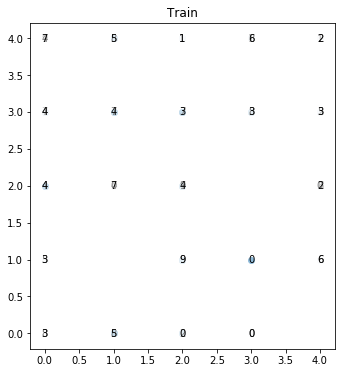

In [12]:
mapped = som.map_vects(x_train)
mappedarr = np.array(mapped)
x1 = mappedarr[:,0]; y1 = mappedarr[:,1]
index = [ np.where(r==1)[0][0] for r in y_train ]
index = list(map(str, index))
plt.figure(1, figsize=(12,6))
plt.subplot(121)
# Plot 1 for Training only
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.title('Train')

The output of the raining is the train dataset are mapped as seen as above. We can improve the accurcary by increase the iterations and the training. 

## Testing

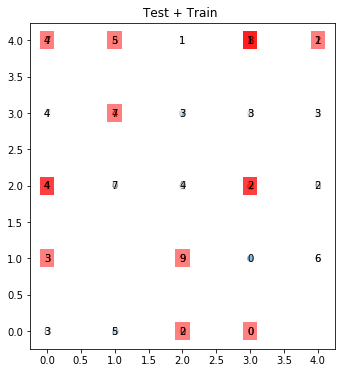

In [10]:
mappedtest = som.map_vects(x_test)
mappedtestarr = np.array(mappedtest)
x2 = mappedtestarr[:,0]
y2 = mappedtestarr[:,1]

index2 = [ np.where(r==1)[0][0] for r in y_test ]
index2 = list(map(str, index2))

plt.figure(1, figsize=(12,6))
plt.subplot(122)
plt.scatter(x1,y1)
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.scatter(x2,y2)
for i, m in enumerate(mappedtest):
    plt.text( m[0], m[1],index2[i], ha='center', va='center', bbox=dict(facecolor='red', alpha=0.5, lw=0))
plt.title('Test + Train ')

plt.show()

The recognizing process be performed by training some data, after the recoginzer already learning the data by updating the weight using SOM algorithm, then the recognizer will use the weight to recognize the new data and mapped them to the right location